# Fiber Network Mesh Generation
This notebook demonstrates how to generate a mesh using the code in `mesh_generation.py`.

## Microtissue Fiber Network Generation
Complete workflow with parameter exploration and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/projectnb/me700/students/quan/assignments/fiber_network_active_contraction/src/fiber_network')
from mesh_generation import (
    FiberNetworkParams, 
    generate_sample_tissue_params,
    generate_fib_net_for_tissue,
    generate_fib_net_xdmf_meshio
)

### 1. Configuration Setup
All available parameters with sample values:

In [2]:
np.random.seed(0)  # For reproducibility

# Generate sample tissue geometry
tissue_pts, posts_pos, posts_radius, wound_shape = generate_sample_tissue_params()

# Full parameter configuration
config = FiberNetworkParams(
    # Tissue geometry (using sample values)
    tissue_points=tissue_pts,
    dimension=2,
    
    # Fiber generation parameters
    num_fibers=250,
    fiber_length={
        "distribution": "normal",  # Options: constant/uniform/normal
        "min": 0.1, # for uniform distribution
        "max": 0.5, # for uniform distribution
        "mean": 0.3, # for normal distribution and constant
        "std_dev": 0.05 # for normal distribution and constant
    },
    fiber_orientation={
        "distribution": "random_orientation",  # Options: random_orientation/uniform/von_mises
        "range": [0, 180],  # For uniform distribution
        "mean_angle": 0,  # For von Mises
        "concentration": 0.0  # For von Mises (higher = more aligned)
    },
    fiber_radii={
        "distribution": "normal",  # Options: constant/uniform/normal
        "mean": 0.01,
        "std_dev": 0.002
    },
    
    # Micropost configuration
    post_positions=posts_pos,
    post_radius=posts_radius,
    post_tolerance=1e-6,
    
    # Wound parameters
    wound_shape=wound_shape,
    
    # Spatial distribution control
    num_patches_x=2,
    num_patches_y=2
)

### 2. Generate and Visualize Network
2D visualization colored by fiber index

In [3]:
# Generate the fiber network
fiber_network = generate_fib_net_for_tissue(config)

In [12]:
def post_boundary(x,post_center,post_r,tol=1e-6):
    return np.sqrt( (x[0]-post_center[0])**2 + (x[1]-post_center[1])**2 ) - post_r <= tol

def post0_subdomain(x):
    return post_boundary(x,post_center_0,post_radius)

def post1_subdomain(x):
    return post_boundary(x,post_center_1,post_radius)

def post2_subdomain(x):
    return post_boundary(x,post_center_2,post_radius)

def post3_subdomain(x):
    return post_boundary(x,post_center_3,post_radius)

def on_posts(x):
    return post0_subdomain(x) or post1_subdomain(x) or post2_subdomain(x) or post3_subdomain(x)

posts_pos = np.array([[0.100917431,0.110091743],[0.899082569,0.110091743],
                        [0.100917431,0.581039755],[0.899082569,0.577981651]])
post_shift = np.array([[1,1],[-1,1],[1,-1],[-1,-1]]) * 0.05
posts_pos+=post_shift
post_center_2,post_center_3,post_center_1,post_center_0 = posts_pos
post_radius = 0.1

fib_len = []
pts_on_posts = []
short_fib = []
for line in fiber_network.fibers:
    p1x,p1y,p2x,p2y = line

    pt1_on_post = on_posts([p1x,p1y])
    pt2_on_post = on_posts([p2x,p2y])
    if pt1_on_post and pt2_on_post:
        pts_on_posts.append([p1x,p1y])
        pts_on_posts.append([p2x,p2y])
        continue

    len_line = np.sqrt( (p1x-p2x)**2 + (p1y-p2y)**2 )
    fib_len.append(len_line)
    if len_line <= 1e-4:
        short_fib.append(line)
fib_len = np.array(fib_len)
short_fib = np.array(short_fib)

print(f'mean fiber length = {np.mean(fib_len)}')
print(f'min fiber length = {np.amin(fib_len)}')
print(f'max fiber length = {np.amax(fib_len)}')
print(f'num short_fib = {short_fib.shape[0]}')

mean fiber length = 0.016728251822042118
min fiber length = 1.3067208369935578e-05
max fiber length = 0.11306711687591961
num short_fib = 20


(array([1273.,  684.,  362.,  171.,   73.,   44.,   25.,   10.,    8.,
           6.]),
 array([1.30672084e-05, 1.13184722e-02, 2.26238771e-02, 3.39292821e-02,
        4.52346871e-02, 5.65400920e-02, 6.78454970e-02, 7.91509020e-02,
        9.04563069e-02, 1.01761712e-01, 1.13067117e-01]),
 <BarContainer object of 10 artists>)

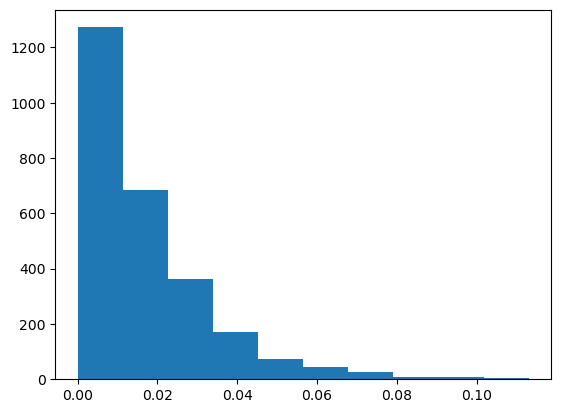

In [5]:
plt.hist(fib_len)

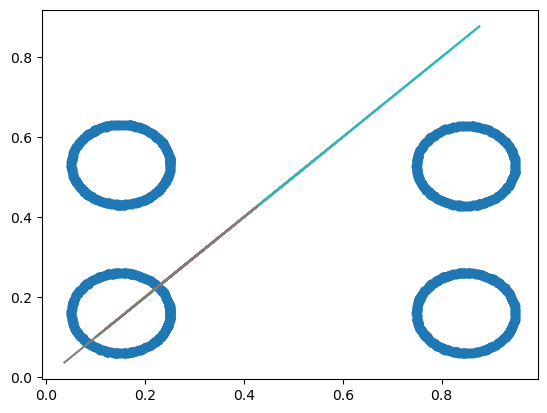

In [11]:
pts_on_posts=np.array(pts_on_posts)

plt.scatter(pts_on_posts[:,0],pts_on_posts[:,1])
for short_line in short_fib:
    plt.plot(short_line[:2],short_line[2:])

In [10]:
print(short_fib)

[[0.10075367 0.40852205 0.10075582 0.40845127]
 [0.10075367 0.40852205 0.1007702  0.40844563]
 [0.10075582 0.40845127 0.1007702  0.40844563]
 [0.12004554 0.31935243 0.12006438 0.31926534]
 [0.12004554 0.31935243 0.12012815 0.31931301]
 [0.12006438 0.31926534 0.12012815 0.31931301]
 [0.20722372 0.34878215 0.20724711 0.34882539]
 [0.20722372 0.34878215 0.20725854 0.34877973]
 [0.20724711 0.34882539 0.20725854 0.34877973]
 [0.29203271 0.58963738 0.29203556 0.58968021]
 [0.29203271 0.58963738 0.29205117 0.5896537 ]
 [0.29203556 0.58968021 0.29205117 0.5896537 ]
 [0.42369438 0.17712862 0.42377896 0.17716548]
 [0.54486184 0.22489682 0.54487951 0.22488425]
 [0.54486184 0.22489682 0.54488667 0.22489518]
 [0.54487951 0.22488425 0.54488667 0.22489518]
 [0.67859875 0.34965504 0.67861687 0.34966417]
 [0.81046819 0.03672595 0.81053796 0.0367218 ]
 [0.87600126 0.43170648 0.87608373 0.43168195]
 [0.87608373 0.43168195 0.8761477  0.43174948]]


In [ ]:
# # Check for duplicate fibers
# unique_fibers = np.unique(fiber_network.fibers, axis=0)
# if len(unique_fibers) != len(fiber_network.fibers):
#     print("Warning: Duplicate fibers detected.")

# # Check for near-zero-length fibers
# fiber_lengths = np.sqrt((fiber_network.fibers[:, 2] - fiber_network.fibers[:, 0])**2 +
#                         (fiber_network.fibers[:, 3] - fiber_network.fibers[:, 1])**2)
# if np.any(fiber_lengths < 1e-6):
#     print("Warning: Near-zero-length fibers detected.")

In [ ]:
# Create colormap for fiber indices
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(fiber_network.indices))

# Plot configuration
plt.figure(figsize=(12, 8), dpi=100)

# Plot fibers with index-based coloring
for idx, fiber in enumerate(fiber_network.fibers):
    plt.plot([fiber[0], fiber[2]], [fiber[1], fiber[3]], 
             color=cmap(norm(fiber_network.indices[idx])), 
             lw=1.0, 
             alpha=0.7)

# Plot microposts
for post in posts_pos:
    plt.gca().add_patch(plt.Circle(post, posts_radius, color='red', alpha=0.4))

posts_pos_test = np.array([[0.100917431,0.110091743],[0.899082569,0.110091743],
                        [0.100917431,0.581039755],[0.899082569,0.577981651]])
post_shift = np.array([[1,1],[-1,1],[1,-1],[-1,-1]]) * 0.05
posts_pos_test+=post_shift
plt.scatter(posts_pos_test[:,0], posts_pos_test[:,1],
            color='red', alpha=1.0) # s=posts_radius*100

# Formatting
plt.xlim(tissue_pts[:,0].min()-0.1, tissue_pts[:,0].max()+0.1)
plt.ylim(tissue_pts[:,1].min()-0.1, tissue_pts[:,1].max()+0.1)
plt.gca().set_aspect('equal')
plt.title("Fiber Network (Colored by Fiber Index)")
plt.xlabel("X Position")
plt.ylabel("Y Position")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.7)
cbar.set_label('Fiber Index')

### 3. Export to XDMF Format
Mesh refinement with characteristic length

In [ ]:
generate_fib_net_xdmf_meshio(
    fiber_network.fibers,
    f_name="microtissue_mesh",
    output_xdmf="./example_files/meshes/",
    fib_ind=fiber_network.indices,
    characteristic_length=0.006
)

print("XDMF export complete. Files saved in ./output/ directory")